In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
import json

from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data_path = 'data/projdata'
metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]
metadata = metadata[pd.notnull(metadata['overview'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44435 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  44435 non-null  object        
 1   belongs_to_collection  4429 non-null   object        
 2   budget                 44435 non-null  float64       
 3   genres                 44435 non-null  object        
 4   homepage               7749 non-null   object        
 5   id                     44435 non-null  object        
 6   imdb_id                44423 non-null  object        
 7   original_language      44425 non-null  object        
 8   original_title         44435 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             44435 non-null  object        
 11  poster_path            44128 non-null  object        
 12  production_companies   44435 non-null  object        
 13  produc

In [4]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(metadata['genre_list'])
label_classes = mlb.classes_

label_classes
label_list = []
for elem in label_classes:
  label_list.append(elem)

final_genres = MultiLabelBinarizer(classes = label_list) 
y = final_genres.fit_transform(metadata['genre_list'])
final_genres.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [5]:
X = metadata['title']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True)

X_train_vector = vectorizer.fit_transform(X_train)
X_val_vector = vectorizer.transform(X_val)

(35548,) (8887,) (35548, 20) (8887, 20)


In [6]:
def pipeline(model, params = None, cv = 5):
    if params == None:
        model.fit(X_train_vector, y_train)
        return(model, model.predict(X_train_vector), model.predict(X_val_vector))
    else:
        model_cv = GridSearchCV(estimator = model, param_grid = params, cv = cv)
        model_cv.fit(X_train_vector, y_train)
        model = model_cv.best_estimator_

        # additional info for heatmap
        train_preds = model.predict(X_train_vector)
        val_preds = model.predict(X_val_vector)

        # Get training and validation scores for each hyperparameter combination
        results_df = pd.DataFrame(model_cv.cv_results_)
            
        return(model, train_preds, val_preds, model_cv, results_df)

In [19]:
tree = DecisionTreeClassifier()

param_dist = {
    'max_depth': [None, 20, 40, 80, 160, 320],  # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if max_samples_leaf is not None 
    'min_samples_split': [2, 5, 10, 15, 20],  # default = 2
    'min_samples_leaf': [1, 5, 10, 15, 20],  # default = 1
    'max_features': ['sqrt', 'log2', None]  # default = None
}


# Call pipeline with RandomizedSearchCV
model, train_preds, val_preds, tree_random_search, results_df = pipeline(tree, param_dist)

target_names = label_list
training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
print("Best hyperparameters:", tree_random_search.best_params_)  # Print the best hyperparameters
print("\nClassification Report - Training:\n", training_report)
print("\nClassification Report - Validation:\n", validation_report)
print("\nAccuracy - Training:", train_accuracy)
print("Accuracy - Validation:", validation_accuracy)

# model, train_preds, val_preds = pipeline(tree)

# target_names = label_list
# training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
# validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
# train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
# validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
# print("Classification Report - Training:\n", training_report)
# print("\nClassification Report - Validation:\n", validation_report)
# print("\nAccuracy - Training:", train_accuracy)
# print("Accuracy - Validation:", validation_accuracy)

Best hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Classification Report - Training:
                  precision    recall  f1-score   support

         Action       0.92      0.73      0.81      5260
      Adventure       0.94      0.67      0.78      2781
      Animation       0.95      0.73      0.83      1530
         Comedy       0.92      0.78      0.84     10254
          Crime       0.94      0.64      0.76      3432
    Documentary       0.92      0.68      0.78      3087
          Drama       0.91      0.85      0.87     15994
         Family       0.93      0.72      0.81      2216
        Fantasy       0.94      0.66      0.78      1850
        Foreign       0.98      0.59      0.74      1311
        History       0.95      0.65      0.77      1090
         Horror       0.93      0.75      0.83      3741
          Music       0.96      0.63      0.76      1274
        Mystery       0.96      0.62      0.75      1

/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sa

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


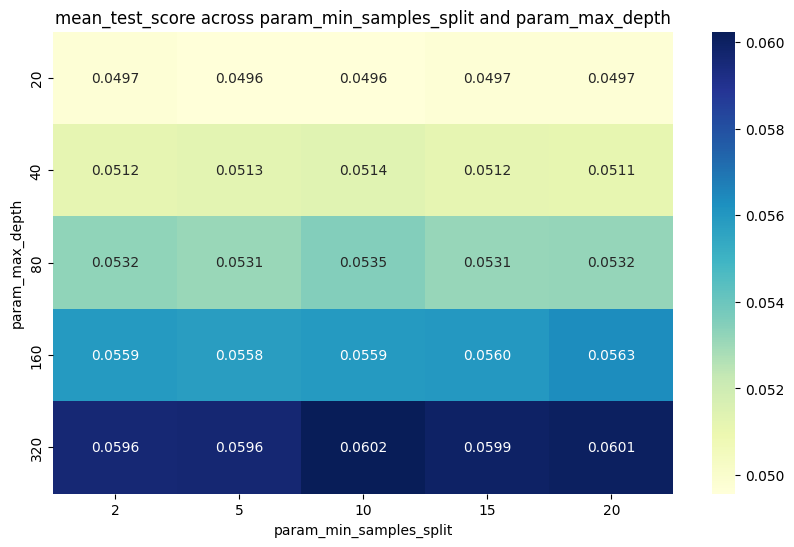

In [36]:
def plot_results(results_df, param1, param2, metric):
    print(results_df.columns)
    pivot_table = results_df.pivot_table(index=param2, columns=param1, values=metric)
    plt.figure(figsize=(10, 6))
    plt.title(f'{metric} across {param1} and {param2}')
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")  # Adjust vmin and vmax here
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.show()

plot_results(results_df, 'param_min_samples_split', 'param_max_depth', 'mean_test_score')


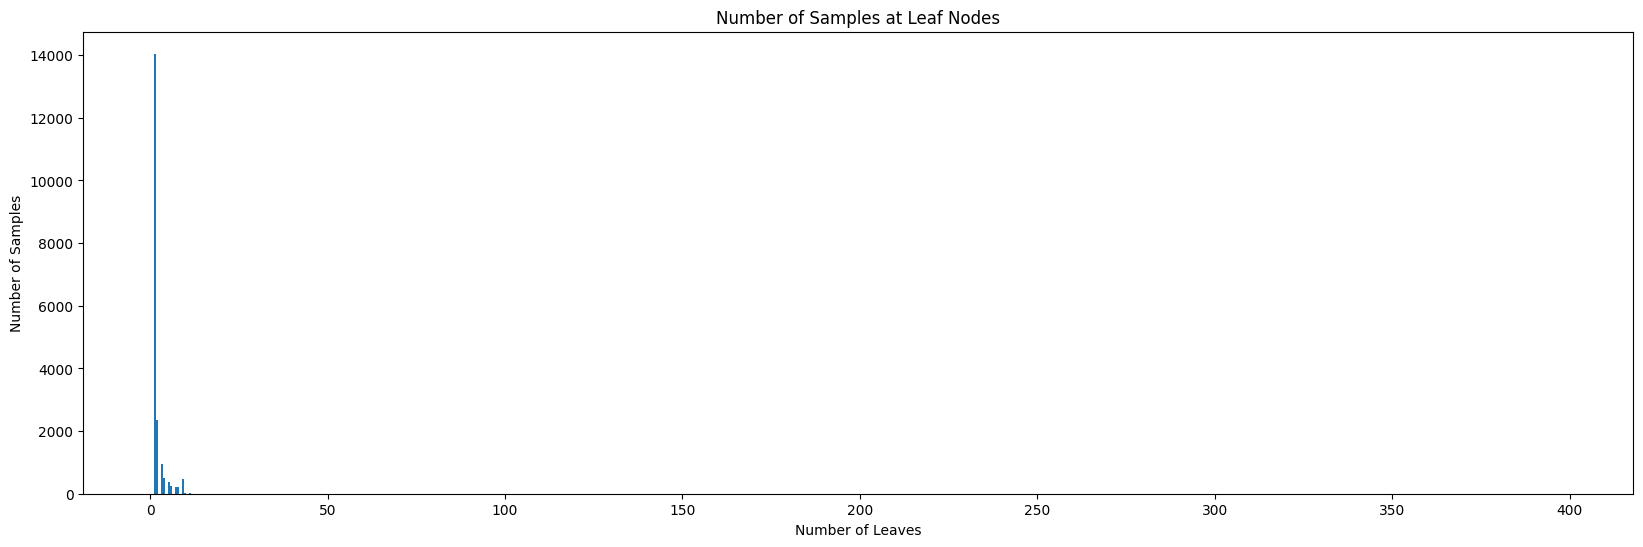

In [37]:
# plotting impurity
def plot_impurity(model):
    plt.figure(figsize=(20, 6))
    plt.title("Number of Samples at Leaf Nodes")
    plt.hist(model.tree_.n_node_samples[model.tree_.children_left == -1], bins=600)
    plt.xlabel("Number of Leaves")
    plt.ylabel("Number of Samples")
    plt.show()

# Plotting impurity
plot_impurity(model)

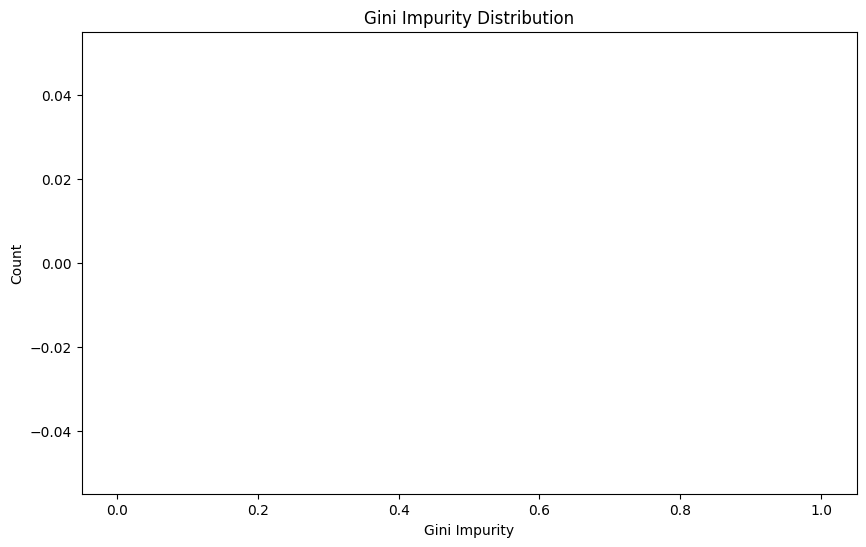

In [41]:
def plot_gini_impurity(tree_model):
    def get_node_gini_impurity(node):
        if 'value' in node.dtype.fields.keys():
            class_counts = node.value[0]
            total_samples = np.sum(class_counts)
            probabilities = class_counts / total_samples
            gini_impurity = 1 - np.sum(probabilities ** 2)
        else:
            gini_impurity = None
        return gini_impurity

    node_stack = [0]
    gini_impurities = []

    while node_stack:
        node_index = node_stack.pop()
        node = tree_model.tree_.__getstate__()['nodes'][node_index]
        
        gini_impurity = get_node_gini_impurity(node)
        if gini_impurity is not None:
            gini_impurities.append(gini_impurity)
        
        if tree_model.tree_.children_left[node_index] != -1:
            node_stack.append(tree_model.tree_.children_left[node_index])
            node_stack.append(tree_model.tree_.children_right[node_index])

    plt.figure(figsize=(10, 6))
    plt.hist(gini_impurities, bins=30)
    plt.title("Gini Impurity Distribution")
    plt.xlabel("Gini Impurity")
    plt.ylabel("Count")
    plt.show()

# Assuming you already have a trained decision tree model named 'model'
plot_gini_impurity(model)


In [42]:
def plot_gini_impurity(tree_model):
    def get_node_gini_impurity(node):
        if 'value' in node.dtype.fields.keys():
            class_counts = node.value[0]
            total_samples = np.sum(class_counts)
            probabilities = class_counts / total_samples
            gini_impurity = 1 - np.sum(probabilities ** 2)
        else:
            gini_impurity = None
        return gini_impurity

    node_stack = [0]
    gini_impurities = []

    while node_stack:
        node_index = node_stack.pop()
        node = tree_model.tree_.__getstate__()['nodes'][node_index]
        
        print("Node index:", node_index)
        print("Node:", node)
        
        gini_impurity = get_node_gini_impurity(node)
        if gini_impurity is not None:
            gini_impurities.append(gini_impurity)
        
        if tree_model.tree_.children_left[node_index] != -1:
            node_stack.append(tree_model.tree_.children_left[node_index])
            node_stack.append(tree_model.tree_.children_right[node_index])

    print("Gini Impurities:", gini_impurities)
    
    if gini_impurities:
        plt.figure(figsize=(10, 6))
        plt.hist(gini_impurities, bins=30)
        plt.title("Gini Impurity Distribution")
        plt.xlabel("Gini Impurity")
        plt.ylabel("Count")
        plt.show()
    else:
        print("No leaf nodes found in the decision tree.")

# Assuming you already have a trained decision tree model named 'model'
plot_gini_impurity(model)


Node index: 0
Node: (1, 38318, 10072, 0.29201828, 0.16127122, 35548, 35548., 1)
Node index: 38318
Node: (38319, 38820, 1660, 0.41323623, 0.12039323, 506, 506., 1)
Node index: 38820
Node: (-1, -1, -2, -2., 0., 1, 1., 0)
Node index: 38319
Node: (38320, 38819, 6141, 0.59480223, 0.11937261, 505, 505., 1)
Node index: 38819
Node: (-1, -1, -2, -2., 0.11875, 4, 4., 0)
Node index: 38320
Node: (38321, 38818, 18583, 0.33624437, 0.1183063, 501, 501., 1)
Node index: 38818
Node: (-1, -1, -2, -2., 0.05, 2, 2., 0)
Node index: 38321
Node: (38322, 38817, 2552, 0.43901137, 0.11766459, 499, 499., 1)
Node index: 38817
Node: (-1, -1, -2, -2., 0., 1, 1., 0)
Node index: 38322
Node: (38323, 38816, 11977, 0.34327838, 0.11712755, 498, 498., 1)
Node index: 38816
Node: (-1, -1, -2, -2., 0., 1, 1., 0)
Node index: 38323
Node: (38324, 38815, 4064, 0.32737398, 0.11661195, 497, 497., 1)
Node index: 38815
Node: (-1, -1, -2, -2., 0.075, 2, 2., 0)
Node index: 38324
Node: (38325, 38814, 10386, 0.33142883, 0.11602979, 495, 